# Import module

The link to get [ImageAnalysis3](https://github.com/zhengpuas47/ImageAnalysis3) 

Or from the Zhuang lab archived [source_tools](https://github.com/ZhuangLab/Chromatin_Analysis_2020_cell/tree/master/sequential_tracing/source)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import anndata
import scanpy as sc
import os

import matplotlib.pyplot as plt

## ImageAnalysis3 and basic modules

In [2]:
# Pu's ImageAnalysis3
%run "C:\Users\shiwei\Documents\ImageAnalysis3\required_files\Startup_py3.py"
sys.path.append(r"C:\Users\shiwei\Documents")

import ImageAnalysis3 as ia
%matplotlib inline

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast


38928


## Chromatin_analysis_tools etc

See **functions** in the repository for [AnalysisTool_Chromatin](../../README.md)

In [3]:
# Chromatin_analysis_tools (ATC)
# Get path for the py containing functions
import os
import sys
import importlib
module_path =r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin'
if module_path not in sys.path:
    sys.path.append(module_path)
    
# import relevant modules
import gene_selection 
importlib.reload(gene_selection)
import gene_to_loci
importlib.reload(gene_to_loci)
import gene_activity
importlib.reload(gene_activity)
import loci_1d_features
importlib.reload(loci_1d_features)  

import atac_to_loci
importlib.reload(atac_to_loci)

<module 'atac_to_loci' from 'C:\\Users\\shiwei\\Documents\\AnalysisTool_Chromatin\\atac_to_loci.py'>

# Define folders

In [4]:
# main folder for postanalysis
postanalysis_folder = r'L:\Shiwei\postanalysis_2024\v0'
# input files for postanalysis
input_folder = os.path.join(postanalysis_folder, 'resources_from_preprocess')

# output file to be generated
output_main_folder = os.path.join(postanalysis_folder, 'method_overview')

output_analysis_folder = os.path.join(output_main_folder, 'analysis')
output_figure_folder = os.path.join(output_main_folder, 'figures')

# make new folder if needed
make_output_folder = True

if make_output_folder and not os.path.exists(output_analysis_folder):
    os.makedirs(output_analysis_folder)
    print(f'Generating analysis folder: {output_analysis_folder}.')
elif os.path.exists(output_analysis_folder):
    print(f'Use existing analysis folder: {output_analysis_folder}.')
    
if make_output_folder and not os.path.exists(output_figure_folder):
    os.makedirs(output_figure_folder)
    print(f'Generating figure folder: {output_figure_folder}.')
elif os.path.exists(output_figure_folder):
    print(f'Use existing figure folder: {output_figure_folder}.')

Use existing analysis folder: L:\Shiwei\postanalysis_2024\v0\method_overview\analysis.
Use existing figure folder: L:\Shiwei\postanalysis_2024\v0\method_overview\figures.


# Plotting parameters

In [5]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
plt.rc('font', serif='Arial')

from ImageAnalysis3.figure_tools import _double_col_width, _single_col_width, _font_size, _ticklabel_size,_ticklabel_width

import seaborn as sns
sns.set_context("paper", rc={"font.size":_font_size,"axes.titlesize":_font_size+1,"axes.labelsize":_font_size})  

In [6]:
# Other required plotting parameters
_dpi = 300
_font_size = 7
_page_width = 5.5

sc.settings.n_jobs = 24
sc.settings.set_figure_params(dpi=_dpi/2, dpi_save=_dpi, frameon=False, 
                              figsize=(_page_width/2, _page_width/2), fontsize=_font_size, facecolor='white', transparent=True)
sc.settings.figdir = output_figure_folder

# Load data relevant information

## load and format codebook

[merged codebook](../resources/merged_codebook.csv) as in the repository (merged for all DNA-MERFISH libraries)

In [7]:
# Load codebook 
codebook_fname = os.path.join(input_folder,'merged_codebook.csv')
codebook_df = pd.read_csv (codebook_fname, index_col=0)

# sort df by chr and chr_order
codebook_df = loci_1d_features.sort_loci_df_by_chr_order (codebook_df)
codebook_df.head()

,name,id,NDB_784,NDB_755,NDB_826,NDB_713,NDB_865,NDB_725,NDB_817,NDB_710,...,NDB_479,NDB_562,NDB_608,NDB_460,NDB_563,NDB_592,NDB_368,NDB_436,NDB_629,NDB_604
0,1:3742742-3759944,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1:6245958-6258969,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1:8740008-8759916,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1016,1:9627926-9637875,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1017,1:9799472-9811359,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [8]:
# Format the chr loci name by 
# 1. changing loci name format
# 2. extract relevant information such as id, chr, chr_order, and library etc
from gene_to_loci import loci_pos_format
loci_name_list = list(map(loci_pos_format, codebook_df['name'].tolist()))
loci_name_arr = np.array(loci_name_list)

# convert to a new dataframe and set loci name as index
codebook_df = codebook_df[['name','id','chr','chr_order','library']]
codebook_df['loci_name'] = list(loci_name_arr[:,0])
codebook_df = codebook_df.set_index ('loci_name')

codebook_df.head()

,name,id,chr,chr_order,library
loci_name,,,,,
chr1_3742742_3759944,1:3742742-3759944,1,1,0.0,CTP11
chr1_6245958_6258969,1:6245958-6258969,2,1,1.0,CTP11
chr1_8740008_8759916,1:8740008-8759916,3,1,2.0,CTP11
chr1_9627926_9637875,1:9627926-9637875,1,1,3.0,CTP13
chr1_9799472_9811359,1:9799472-9811359,2,1,4.0,CTP13


# Load medianDict for different replicate

replicate data can be generated using the notebook below:

[preprocess/2_dna_merfish/scripts/2_spot_pick/4_2_split_summary_to_dict_by_replicate](../../../preprocess/2_dna_merfish/scripts/2_spot_pick/4_2_split_summary_to_dict_by_replicate.ipynb)

In [9]:
class_2_medianDict_byExp = {}
class_2_infoDict_byExp = {}

for _exp_key in ['20220304', '20220329', '20220415', '20220418']:

    class_2_medianDict_filename = os.path.join(input_folder, f'{_exp_key}_subclass_2_medianDict.pkl')
    if os.path.exists(class_2_medianDict_filename):
        class_2_medianDict = pickle.load(open(class_2_medianDict_filename, 'rb'))
        class_2_medianDict_byExp[_exp_key] = class_2_medianDict


    class_2_infoDict_filename = os.path.join(input_folder, f'{_exp_key}_subclass_2_cellInfo.pkl')
    if os.path.exists(class_2_infoDict_filename):
        class_2_infoDict = pickle.load(open(class_2_infoDict_filename, 'rb'))
        class_2_infoDict_byExp[_exp_key] = class_2_infoDict

In [10]:
class_2_medianDict_byExp.keys()

dict_keys(['20220304', '20220329', '20220415', '20220418'])

In [11]:
class_2_medianDict.keys()

dict_keys(['Oligo', 'L6b', 'Astro', 'SMC', 'OPC', 'Endo', 'Lamp5', 'L6 CT', 'Peri', 'Micro', 'L6 IT', 'Vip', 'L2/3 IT', 'Sst', 'L4/5 IT', 'Pvalb', 'L5 IT', 'L5/6 NP', 'L5 ET', 'Sncg', 'VLMC'])

# Plot distance matrices for visualization

In [12]:
import ImageAnalysis3.structure_tools.distance as distance
sort_by_region = False
chr_2_indices, chr_2_orders = distance.Generate_PlotOrder(codebook_df, codebook_df, sort_by_region=sort_by_region)

meta NOT subset; don't know how to subset; dropped
C:\Users\shiwei\AppData\Local\Temp\3\ipykernel_38928\4251232464.py:59: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
meta NOT subset; don't know how to subset; dropped


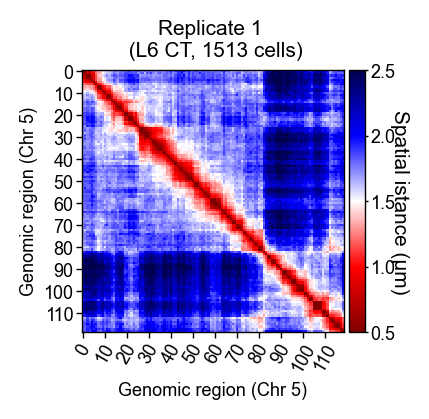

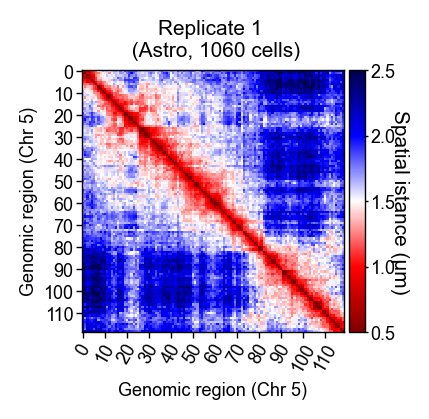

In [13]:
#%matplotlib notebook
%matplotlib inline
from matplotlib.colors import LogNorm

#plt.style.use('dark_background')
#plt.style.use('default')

_single_im_size=3
sel_codebook = codebook_df
sort_by_region = False

_exp_key = '20220329'
class_2_medianDict = class_2_medianDict_byExp[_exp_key]
class_2_infoDict = class_2_infoDict_byExp[_exp_key]

#_class = 'neuron'
chosen_chrom = '5'

#for _class in ['L2/3 IT', 'L6 CT','Pvalb','Astro','Oligo']:
for _class in ['L6 CT', 'Astro']:
    summary_dict = class_2_medianDict[_class]

    _cis_mat, chr_edges, chr_names = distance.assemble_ChrDistDict_2_Matrix(
            summary_dict, codebook_df, 
            sel_codebook=sel_codebook, 
            use_cis=True, sort_by_region=sort_by_region,
        )

    _chr_indices = chr_2_indices[chosen_chrom]
    cis_mat_chr = _cis_mat[:,_chr_indices]
    cis_mat_chr = cis_mat_chr[_chr_indices,:]

    fig, axes = plt.subplots(1, 1, figsize=(_page_width/3.5, _page_width/3.5*1.1), dpi=100, sharex=True, sharey=True)

    ia.figure_tools.distmap.plot_distance_map(cis_mat_chr, color_limits=[0.5,2.5],
                                              ax=axes, 
                                              ticks=[i for i in np.arange(0,len(cis_mat_chr)) if i%10==0],
                                              tick_labels=[i for i in np.arange(0,len(cis_mat_chr)) if i%10==0],
                                              ax_label= f'Genomic region (Chr {chosen_chrom})', 
                                              colorbar_labels = 'Spatial istance (\u03BCm)',
                                              colorbar_kwargs={'pad':3}, 
                                              font_size=_font_size-0.5)



    axes.grid(False)
    axes.set_title(f'Replicate 1 \n ({_class}, {len(class_2_infoDict[_class])} cells)', fontsize=_font_size+0.5, pad=5)

    axes.hlines(chr_edges-0.5, 0, len(_cis_mat), color='black', linewidth=0.2)
    axes.vlines(chr_edges-0.5, 0, len(_cis_mat), color='black', linewidth=0.2)
    axes.xaxis.set_tick_params(which='both', labelbottom=True)
    axes.yaxis.set_tick_params(which='both', labelleft=True)

    fig.subplots_adjust(wspace=0.2, hspace=0.2, left=0.05, right=0.95, top=0.97, bottom=0.02)
    #fig.suptitle(f"{_class}, N={len(class_2_chr_zxys[_class])}", fontsize=10, y=0.97)
    #fig.suptitle(f"{_class}, N={len(class_2_cellInfoList[_class])}", fontsize=10, y=0.97)
    fig.savefig(os.path.join(output_figure_folder, f"cis_distmap_{_class.replace('/','_')}_chr_{chosen_chrom}_{_exp_key}.pdf"),
                transparent=True,bbox_inches='tight', dpi=300)
    fig.show()

meta NOT subset; don't know how to subset; dropped
C:\Users\shiwei\AppData\Local\Temp\3\ipykernel_38928\745512671.py:60: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
meta NOT subset; don't know how to subset; dropped


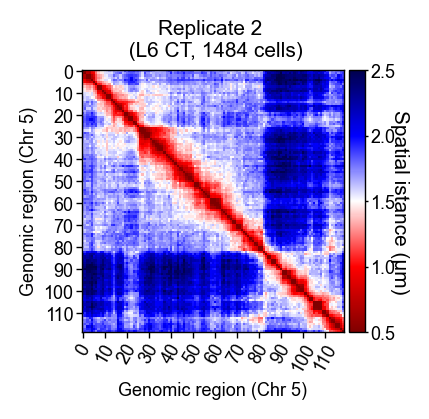

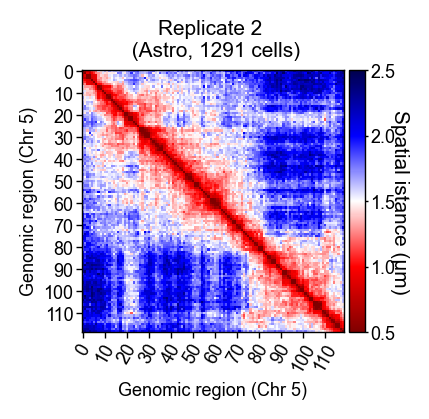

In [14]:
#%matplotlib notebook
%matplotlib inline
from matplotlib.colors import LogNorm

#plt.style.use('dark_background')
#plt.style.use('default')

_single_im_size=3
sel_codebook = codebook_df
sort_by_region = False

#_exp_key = '20220418'
_exp_key = '20220415'

class_2_medianDict = class_2_medianDict_byExp[_exp_key]
class_2_infoDict = class_2_infoDict_byExp[_exp_key]

#_class = 'neuron'
chosen_chrom = '5'

#for _class in ['L2/3 IT', 'L6 CT','Pvalb','Astro','Oligo']:
for _class in ['L6 CT', 'Astro']:
    summary_dict = class_2_medianDict[_class]

    _cis_mat, chr_edges, chr_names = distance.assemble_ChrDistDict_2_Matrix(
            summary_dict, codebook_df, 
            sel_codebook=sel_codebook, 
            use_cis=True, sort_by_region=sort_by_region,
        )

    _chr_indices = chr_2_indices[chosen_chrom]
    cis_mat_chr = _cis_mat[:,_chr_indices]
    cis_mat_chr = cis_mat_chr[_chr_indices,:]

    fig, axes = plt.subplots(1, 1, figsize=(_page_width/3.5, _page_width/3.5*1.1), dpi=100, sharex=True, sharey=True)

    ia.figure_tools.distmap.plot_distance_map(cis_mat_chr, color_limits=[0.5,2.5],
                                              ax=axes, 
                                              ticks=[i for i in np.arange(0,len(cis_mat_chr)) if i%10==0],
                                              tick_labels=[i for i in np.arange(0,len(cis_mat_chr)) if i%10==0],
                                              ax_label= f'Genomic region (Chr {chosen_chrom})', 
                                              colorbar_labels = 'Spatial istance (\u03BCm)',
                                              colorbar_kwargs={'pad':2}, 
                                              font_size=_font_size-0.5)


    axes.grid(False)
    axes.set_title(f'Replicate 2 \n ({_class}, {len(class_2_infoDict[_class])} cells)', fontsize=_font_size+0.5, pad=5)

    axes.hlines(chr_edges-0.5, 0, len(_cis_mat), color='black', linewidth=0.2)
    axes.vlines(chr_edges-0.5, 0, len(_cis_mat), color='black', linewidth=0.2)
    axes.xaxis.set_tick_params(which='both', labelbottom=True)
    axes.yaxis.set_tick_params(which='both', labelleft=True)

    fig.subplots_adjust(wspace=0.2, hspace=0.2, left=0.05, right=0.95, top=0.97, bottom=0.02)
    #fig.suptitle(f"{_class}, N={len(class_2_chr_zxys[_class])}", fontsize=10, y=0.97)
    #fig.suptitle(f"{_class}, N={len(class_2_cellInfoList[_class])}", fontsize=10, y=0.97)
    fig.savefig(os.path.join(output_figure_folder, f"cis_distmap_{_class.replace('/','_')}_chr_{chosen_chrom}_{_exp_key}.pdf"),
                transparent=True,bbox_inches='tight', dpi=300)
    fig.show()

# Plot correlation for all chromosomes

In [15]:
from sklearn.linear_model import LinearRegression
from ImageAnalysis3.structure_tools.distance import sort_chr

## L6 CT

In [16]:
_single_im_size=3
sel_codebook = codebook_df
sort_by_region = False

chr_2_indices, chr_2_orders = distance.Generate_PlotOrder(codebook_df, codebook_df, sort_by_region=sort_by_region)


all_sorted_chr = [str(i) for i in range(1,20)]
all_sorted_chr.append('X')
#print(all_sorted_chr[:2])


_class = 'L6 CT'

# select two replicates
sel_exp_1 = '20220329'
#sel_exp_2 = '20220418'
sel_exp_2 = '20220415'

chr_medianDict_byRep = {}

for _sel_exp in [sel_exp_1, sel_exp_2]:
    summary_dict = class_2_medianDict_byExp[_sel_exp][_class]
    _cis_mat, chr_edges, chr_names = distance.assemble_ChrDistDict_2_Matrix(
            summary_dict, codebook_df, 
            sel_codebook=sel_codebook, 
            use_cis=True, sort_by_region=sort_by_region,
        )

    # make chr_map dict from the full_cis_mat
    chr_medianDict = {}
    for _i, _chr in enumerate(all_sorted_chr):

        _chr_indices = chr_2_indices[_chr]
        cis_mat_chr = _cis_mat[:,_chr_indices]
        cis_mat_chr = cis_mat_chr[_chr_indices,:]

        chr_medianDict[f'cis_{_chr}']=cis_mat_chr
    
    chr_medianDict_byRep[_sel_exp] = chr_medianDict

In [17]:
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression

meta NOT subset; don't know how to subset; dropped


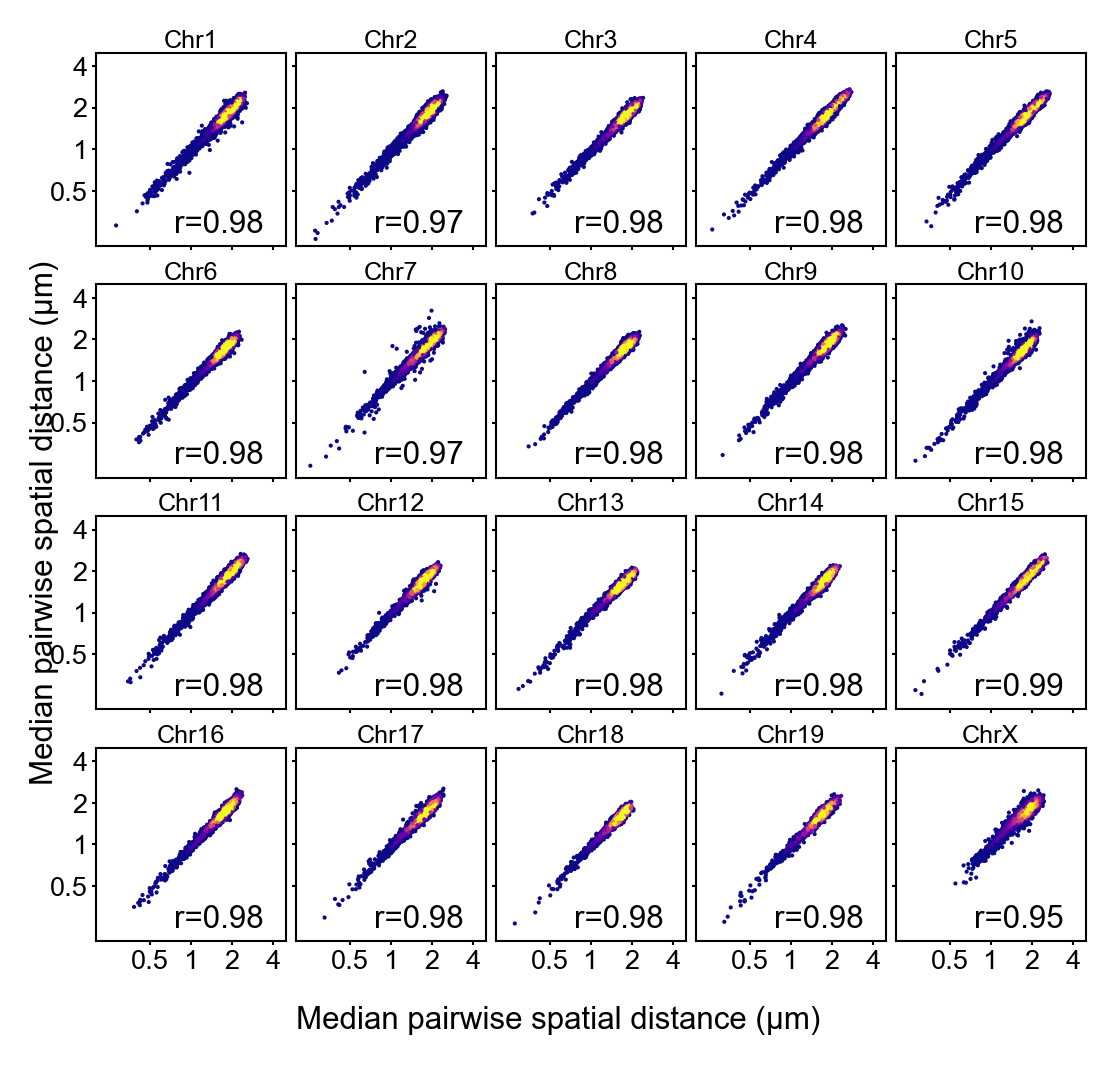

In [19]:
%matplotlib inline

from mpl_toolkits.axes_grid1 import make_axes_locatable


#plt.style.use('default')
num_rows, num_cols = 4,5

fig, axes_list = plt.subplots(num_rows, num_cols,figsize=(_page_width/1.5,_page_width/1.5*0.95), 
                              sharex=True, sharey=True, dpi=150)
#chr_2_hic_mat['1']

_ax_list = np.ravel(axes_list)


spearman_corr_dict = {}



for _i, _chr in enumerate(all_sorted_chr[:]):
    # extract axis
    _ax = _ax_list[_i]

    # extract mat for merfish
    _median_mat_1 = chr_medianDict_byRep[sel_exp_1][f'cis_{_chr}']
    _median_mat_2 = chr_medianDict_byRep[sel_exp_2][f'cis_{_chr}']
    
    # unravel
    _median_entries_1 = _median_mat_1[np.triu_indices(len(_median_mat_1),1)]
    _median_entries_2 = _median_mat_2[np.triu_indices(len(_median_mat_2),1)]
    _valid_inds = (_median_entries_1 > 0) & (_median_entries_2 > 0) 
    _median_entries_1 = _median_entries_1[_valid_inds]
    _median_entries_2 = _median_entries_2[_valid_inds]
    
    corr, p = spearmanr(_median_entries_1, _median_entries_2)
    spearman_corr_dict[_chr]=corr

    # calculate color
    values = np.vstack([np.log(_median_entries_1), np.log(_median_entries_2)])
    kernel = scipy.stats.gaussian_kde(values)(values)
    #vmin,vmax = scipy.stats.scoreatpercentile(kernel,10),scipy.stats.scoreatpercentile(kernel,90)

    # plot
    _sct = sns.scatterplot(x=_median_entries_1, y=_median_entries_2, 
                           c=kernel, cmap='plasma', vmin=1, vmax=10,
                           linewidth=0, s=1,rasterized=True,
                           ax=_ax)
    _ax.set_xscale('log')
    _ax.set_yscale('log')
    _ax.set_xticks([0.5,1,2,4])
    _ax.set_xticklabels([0.5,1,2,4])
    _ax.set_yticks([0.5,1,2,4])
    _ax.set_yticklabels([0.5,1,2,4])
    
    _ax.set_xlim([0.2, 5])
    _ax.set_ylim([0.2, 5])
    _ax.minorticks_off()
    
    # legend for coefficient
    _x = np.log(_median_entries_1)[:,np.newaxis]
    _y = np.log(_median_entries_2)
    _reg = LinearRegression().fit(_x,_y)
    _r = np.sqrt(_reg.score(_x,_y))

    _ax.text(x=0.75, y=0.25, s=f'r={_r:.2f}', fontsize=7.5)
    #_ax.text(x=0.28, y=7, s=f'spr={corr:.2f}', fontsize=_font_size-2)
    # title and labels
    _ax.set_title(f"Chr{_chr}", fontsize=_font_size-1, pad=1)
    # formatting
    _ax.tick_params('both', labelsize=_font_size-0.5, 
                    width=_ticklabel_width, length=_ticklabel_size-1,
                    labelleft=False,labelbottom=False, pad=1,) 
    [i[1].set_linewidth(_ticklabel_width) for i in _ax.spines.items()]
    _ax.grid(False)
    
    
# delete empty axes
for _null_ax in _ax_list[len(all_sorted_chr):]:
    fig.delaxes(_null_ax)

fig.subplots_adjust(wspace=0.05, hspace=0.2, left=0.08, right=0.98, top=0.95, bottom=0.1)
# label the left most one
for _axes in axes_list:
    _axes[0].tick_params('y', labelleft=True,pad=1,) 
    
# label the bottom most row
for _ax in axes_list[-1]:
    _ax.tick_params('x', labelbottom=True,pad=1,) 
        

fig.supxlabel('Median pairwise spatial distance (\u03BCm)', fontsize=_font_size+0.5, )
fig.supylabel('Median pairwise spatial distance (\u03BCm)', fontsize=_font_size+0.5, )
plt.savefig(os.path.join(output_figure_folder, f"cis_correlation_scatter_median_replicate_{_class.replace('/','_')}.pdf"),
            transparent=True, bbox_inches='tight', pad_inches=0.1, dpi=300)
plt.savefig(os.path.join(output_figure_folder, f"cis_correlation_scatter_median_replicate_{_class.replace('/','_')}.png"),
            transparent=True, bbox_inches='tight', pad_inches=0.1, dpi=300)
plt.show()